<a href="https://colab.research.google.com/github/PriyanshuRao-code/AI-Lab-Project/blob/main/team_24_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Don't do anything here. It's just a setup.
import os
import sys

repo_name = "AI-Lab-Project"
repo_url = "https://github.com/PriyanshuRao-code/AI-Lab-Project.git"
repo_path = f"/content/{repo_name}"

if os.path.exists(repo_path):
    print("Repository already exists at:", repo_path)
else:
    print("🚀 Cloning the repository...")
    os.system(f"git clone {repo_url}")

os.chdir(repo_path)
sys.path.append(repo_path)

print("Repository is ready to use at:", repo_path)

🚀 Cloning the repository...
Repository is ready to use at: /content/AI-Lab-Project


In [ ]:
# Using supporting files (now as .ipynb and later .py)

!pip install import-ipynb
import import_ipynb
from team_24_data_preprocessing import *
from team_24_supervised_learning import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.7 MB/s eta 0:00:00
Repository already exists at: /content/AI-Lab-Project
Repository is ready to use at: /content/AI-Lab-Project
Repository already exists at: /content/AI-Lab-Project
Repository is ready to use at: /content/AI-Lab-Project


In [22]:
df = pd.read_csv('24.csv')

In [72]:
import pandas as pd
import numpy as np

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
def remove_outliers_zscore(df_train, df_valid, df_test, z_score_threshold = 3):

  df_train_numeric = df_train.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_train_non_numeric = df_train.select_dtypes(exclude=['number'])

  z_scores = df_train_numeric.apply(zscore)
  df_z = df_train_numeric[(z_scores.abs() < z_score_threshold).all(axis=1)]  # Remove rows with Z-score >  z_score_threshold in any column
  df_train_cleaned = pd.concat([df_z, df_train_non_numeric.loc[df_z.index]], axis=1)

  return df_train_cleaned, df_valid, df_test

In [58]:
def label_encode_categorical(df_train, df_valid, df_test):

  categorical_cols = df_train.select_dtypes(include=['object']).columns
  label_encoders = {}

  for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df_train[col] = label_encoders[col].fit_transform(df_train[col])

    df_valid[col] = df_valid[col].map(lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1)
    df_test[col] = df_test[col].map(lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1)

  df_valid = df_valid[df_train.columns]
  df_test = df_test[df_train.columns]

  return df_train, df_valid, df_test

In [59]:
def standardize_data(df_train_orig, df_valid_orig, df_test_orig):
  df_train = df_train_orig.copy()
  df_valid = df_valid_orig.copy()
  df_test = df_test_orig.copy()
  scaler = StandardScaler()

  df_train_numeric = df_train.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_test_numeric = df_test.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_valid_numeric = df_valid.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])

  # Standardization
  df_train[df_train_numeric.columns] = scaler.fit_transform(df_train_numeric)
  df_test[df_test_numeric.columns] = scaler.transform(df_test_numeric)
  df_valid[df_valid_numeric.columns] = scaler.transform(df_valid_numeric)

  return df_train, df_valid, df_test

In [60]:
def perform_pca(df_train, df_valid, df_test, target_col="Hazardous", n_components=3):

  # Split features & target
  X_train = df_train.drop(columns=[target_col])
  X_valid = df_valid.drop(columns=[target_col])
  X_test  = df_test.drop(columns=[target_col])

  y_train = df_train[target_col].reset_index(drop=True)
  y_valid = df_valid[target_col].reset_index(drop=True)
  y_test  = df_test[target_col].reset_index(drop=True)

  # PCA
  pca = PCA(n_components=n_components)
  pca.fit(X_train)

  X_train_pca = pd.DataFrame(pca.transform(X_train), columns=[f'PC{i+1}' for i in range(n_components)])
  X_valid_pca = pd.DataFrame(pca.transform(X_valid), columns=[f'PC{i+1}' for i in range(n_components)])
  X_test_pca  = pd.DataFrame(pca.transform(X_test),  columns=[f'PC{i+1}' for i in range(n_components)])

  # Add target back
  df_train_pca = pd.concat([X_train_pca, y_train], axis=1)
  df_valid_pca = pd.concat([X_valid_pca, y_valid], axis=1)
  df_test_pca  = pd.concat([X_test_pca,  y_test],  axis=1)

  return df_train_pca, df_valid_pca, df_test_pca

In [61]:
def train_model_random_forest(df_train, df_valid, df_test, target_column="Hazardous"):

    X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)

    X_train_rf = np.array(X_train)
    X_valid_rf = np.array(X_valid)
    X_test_rf = np.array(X_test)

    y_train_rf = np.array(y_train)
    y_valid_rf = np.array(y_valid)
    y_test_rf = np.array(y_test)

    random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
    random_forest.fit(X_train_rf, y_train_rf)

    y_valid_pred_rf = random_forest.predict(X_valid_rf)
    y_test_pred_rf = random_forest.predict(X_test_rf)

    return random_forest, y_valid_rf, y_test_rf, y_valid_pred_rf, y_test_pred_rf

In [62]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

def evaluate_model(y_true, y_pred, model_name="Model", return_metrics=False):
    print(f"\nEvaluation Metrics for {model_name}:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=["Not Hazardous", "Hazardous"], yticklabels=["Not Hazardous", "Hazardous"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n=== Evaluation Report for {model_name} ===")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    if return_metrics:
        return {
            'accuracy': accuracy,
            'recall': recall,
            'precision': precision,
            'f1_score': f1
        }

In [63]:
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df["Hazardous"])
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp["Hazardous"])

In [64]:
df_train, df_valid, df_test = remove_outliers_zscore(df_train, df_valid, df_test)

In [65]:
df_train, df_valid, df_test = label_encode_categorical(df_train, df_valid, df_test)

In [66]:
df_train, df_valid, df_test = standardize_data(df_train, df_valid, df_test)


===== Evaluating Random Forest with PCA (n_components=2) =====

Evaluation Metrics for Random Forest with PCA-2:


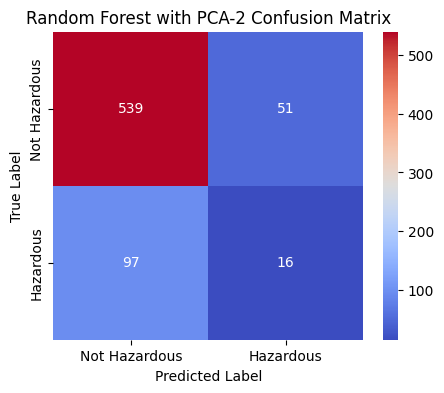


=== Evaluation Report for Random Forest with PCA-2 ===
Accuracy : 0.7895
Recall   : 0.1416
Precision: 0.2388
F1 Score : 0.1778

Classification Report:
               precision    recall  f1-score   support

       False       0.85      0.91      0.88       590
        True       0.24      0.14      0.18       113

    accuracy                           0.79       703
   macro avg       0.54      0.53      0.53       703
weighted avg       0.75      0.79      0.77       703


===== Evaluating Random Forest with PCA (n_components=3) =====

Evaluation Metrics for Random Forest with PCA-3:


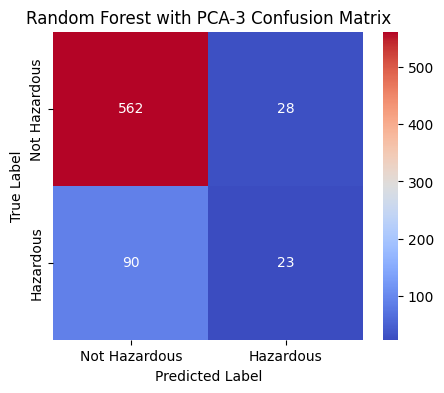


=== Evaluation Report for Random Forest with PCA-3 ===
Accuracy : 0.8321
Recall   : 0.2035
Precision: 0.4510
F1 Score : 0.2805

Classification Report:
               precision    recall  f1-score   support

       False       0.86      0.95      0.90       590
        True       0.45      0.20      0.28       113

    accuracy                           0.83       703
   macro avg       0.66      0.58      0.59       703
weighted avg       0.80      0.83      0.80       703


===== Evaluating Random Forest with PCA (n_components=4) =====

Evaluation Metrics for Random Forest with PCA-4:


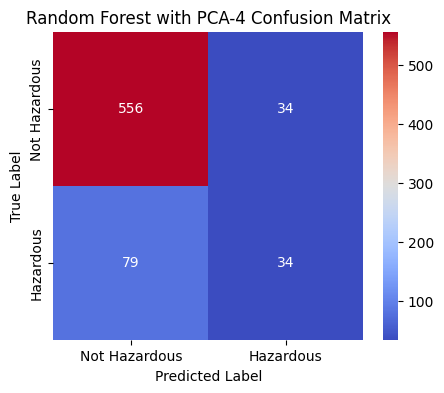


=== Evaluation Report for Random Forest with PCA-4 ===
Accuracy : 0.8393
Recall   : 0.3009
Precision: 0.5000
F1 Score : 0.3757

Classification Report:
               precision    recall  f1-score   support

       False       0.88      0.94      0.91       590
        True       0.50      0.30      0.38       113

    accuracy                           0.84       703
   macro avg       0.69      0.62      0.64       703
weighted avg       0.82      0.84      0.82       703


===== Evaluating Random Forest with PCA (n_components=5) =====

Evaluation Metrics for Random Forest with PCA-5:


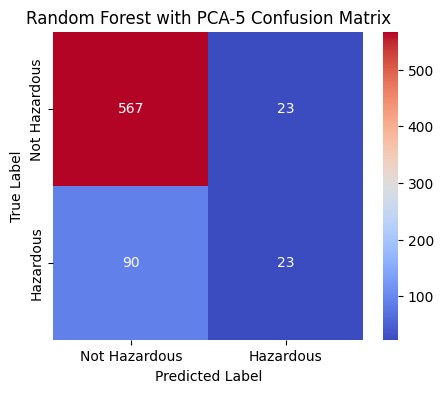


=== Evaluation Report for Random Forest with PCA-5 ===
Accuracy : 0.8393
Recall   : 0.2035
Precision: 0.5000
F1 Score : 0.2893

Classification Report:
               precision    recall  f1-score   support

       False       0.86      0.96      0.91       590
        True       0.50      0.20      0.29       113

    accuracy                           0.84       703
   macro avg       0.68      0.58      0.60       703
weighted avg       0.80      0.84      0.81       703


===== Evaluating Random Forest with PCA (n_components=6) =====

Evaluation Metrics for Random Forest with PCA-6:


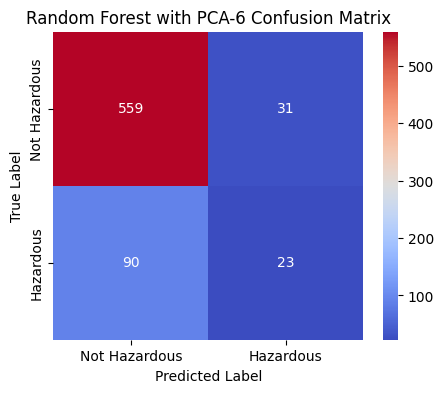


=== Evaluation Report for Random Forest with PCA-6 ===
Accuracy : 0.8279
Recall   : 0.2035
Precision: 0.4259
F1 Score : 0.2754

Classification Report:
               precision    recall  f1-score   support

       False       0.86      0.95      0.90       590
        True       0.43      0.20      0.28       113

    accuracy                           0.83       703
   macro avg       0.64      0.58      0.59       703
weighted avg       0.79      0.83      0.80       703


===== Evaluating Random Forest with PCA (n_components=7) =====

Evaluation Metrics for Random Forest with PCA-7:


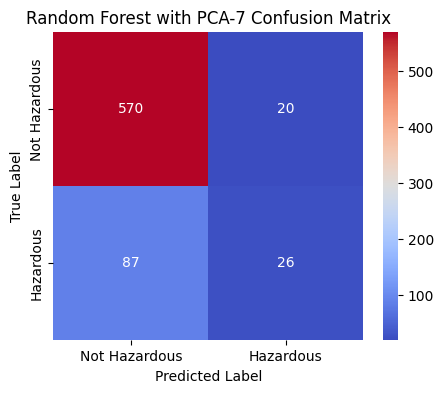


=== Evaluation Report for Random Forest with PCA-7 ===
Accuracy : 0.8478
Recall   : 0.2301
Precision: 0.5652
F1 Score : 0.3270

Classification Report:
               precision    recall  f1-score   support

       False       0.87      0.97      0.91       590
        True       0.57      0.23      0.33       113

    accuracy                           0.85       703
   macro avg       0.72      0.60      0.62       703
weighted avg       0.82      0.85      0.82       703


===== Evaluating Random Forest with PCA (n_components=8) =====

Evaluation Metrics for Random Forest with PCA-8:


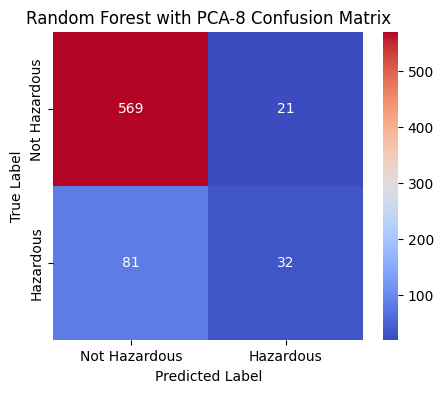


=== Evaluation Report for Random Forest with PCA-8 ===
Accuracy : 0.8549
Recall   : 0.2832
Precision: 0.6038
F1 Score : 0.3855

Classification Report:
               precision    recall  f1-score   support

       False       0.88      0.96      0.92       590
        True       0.60      0.28      0.39       113

    accuracy                           0.85       703
   macro avg       0.74      0.62      0.65       703
weighted avg       0.83      0.85      0.83       703


===== Evaluating Random Forest with PCA (n_components=9) =====

Evaluation Metrics for Random Forest with PCA-9:


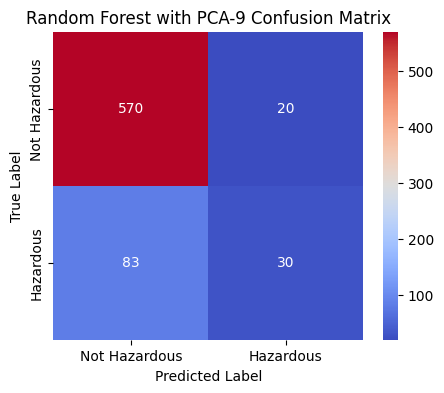


=== Evaluation Report for Random Forest with PCA-9 ===
Accuracy : 0.8535
Recall   : 0.2655
Precision: 0.6000
F1 Score : 0.3681

Classification Report:
               precision    recall  f1-score   support

       False       0.87      0.97      0.92       590
        True       0.60      0.27      0.37       113

    accuracy                           0.85       703
   macro avg       0.74      0.62      0.64       703
weighted avg       0.83      0.85      0.83       703


===== Evaluating Random Forest with PCA (n_components=10) =====

Evaluation Metrics for Random Forest with PCA-10:


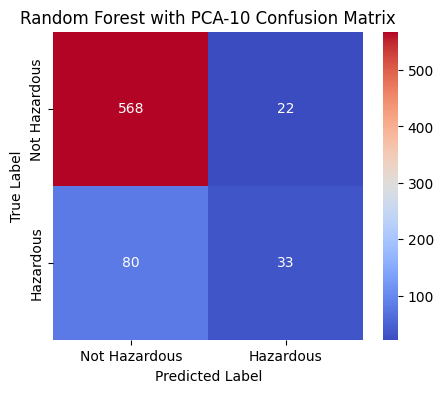


=== Evaluation Report for Random Forest with PCA-10 ===
Accuracy : 0.8549
Recall   : 0.2920
Precision: 0.6000
F1 Score : 0.3929

Classification Report:
               precision    recall  f1-score   support

       False       0.88      0.96      0.92       590
        True       0.60      0.29      0.39       113

    accuracy                           0.85       703
   macro avg       0.74      0.63      0.66       703
weighted avg       0.83      0.85      0.83       703



In [67]:
metrics_summary = []

for n_components in range(2, 11):
    print(f"\n===== Evaluating Random Forest with PCA (n_components={n_components}) =====")

    df_train_pca, df_valid_pca, df_test_pca = perform_pca(df_train, df_valid, df_test, n_components=n_components)
    model, y_valid_true, y_test_true, y_valid_pred, y_test_pred = train_model_random_forest(
        df_train_pca, df_valid_pca, df_test_pca
    )

    metrics = evaluate_model(y_valid_true, y_valid_pred, model_name=f"Random Forest with PCA-{n_components}", return_metrics=True)

    metrics_summary.append({
        'n_components': n_components,
        'accuracy': metrics['accuracy'],
        'recall': metrics['recall'],
        'precision': metrics['precision'],
        'f1_score': metrics['f1_score']
    })


In [68]:
metrics_df = pd.DataFrame(metrics_summary)

best_accuracy_pca = metrics_df.loc[metrics_df['accuracy'].idxmax(), 'n_components']
best_recall_pca = metrics_df.loc[metrics_df['recall'].idxmax(), 'n_components']
best_precision_pca = metrics_df.loc[metrics_df['precision'].idxmax(), 'n_components']
best_f1_pca = metrics_df.loc[metrics_df['f1_score'].idxmax(), 'n_components']

print("\n========= Best PCA Results =========")
print(f"Highest Accuracy: PCA Components = {best_accuracy_pca}")
print(f"Highest Recall: PCA Components = {best_recall_pca}")
print(f"Highest Precision: PCA Components = {best_precision_pca}")
print(f"Highest F1-Score: PCA Components = {best_f1_pca}")


========= Best PCA Results =========
Highest Accuracy: PCA Components = 8
Highest Recall: PCA Components = 4
Highest Precision: PCA Components = 8
Highest F1-Score: PCA Components = 10
